# Setup

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

# Example image

In [86]:
image = Image.open('../../videos/extracted/fridge_open/00090.jpg')
image = np.array(image.convert("RGB"))

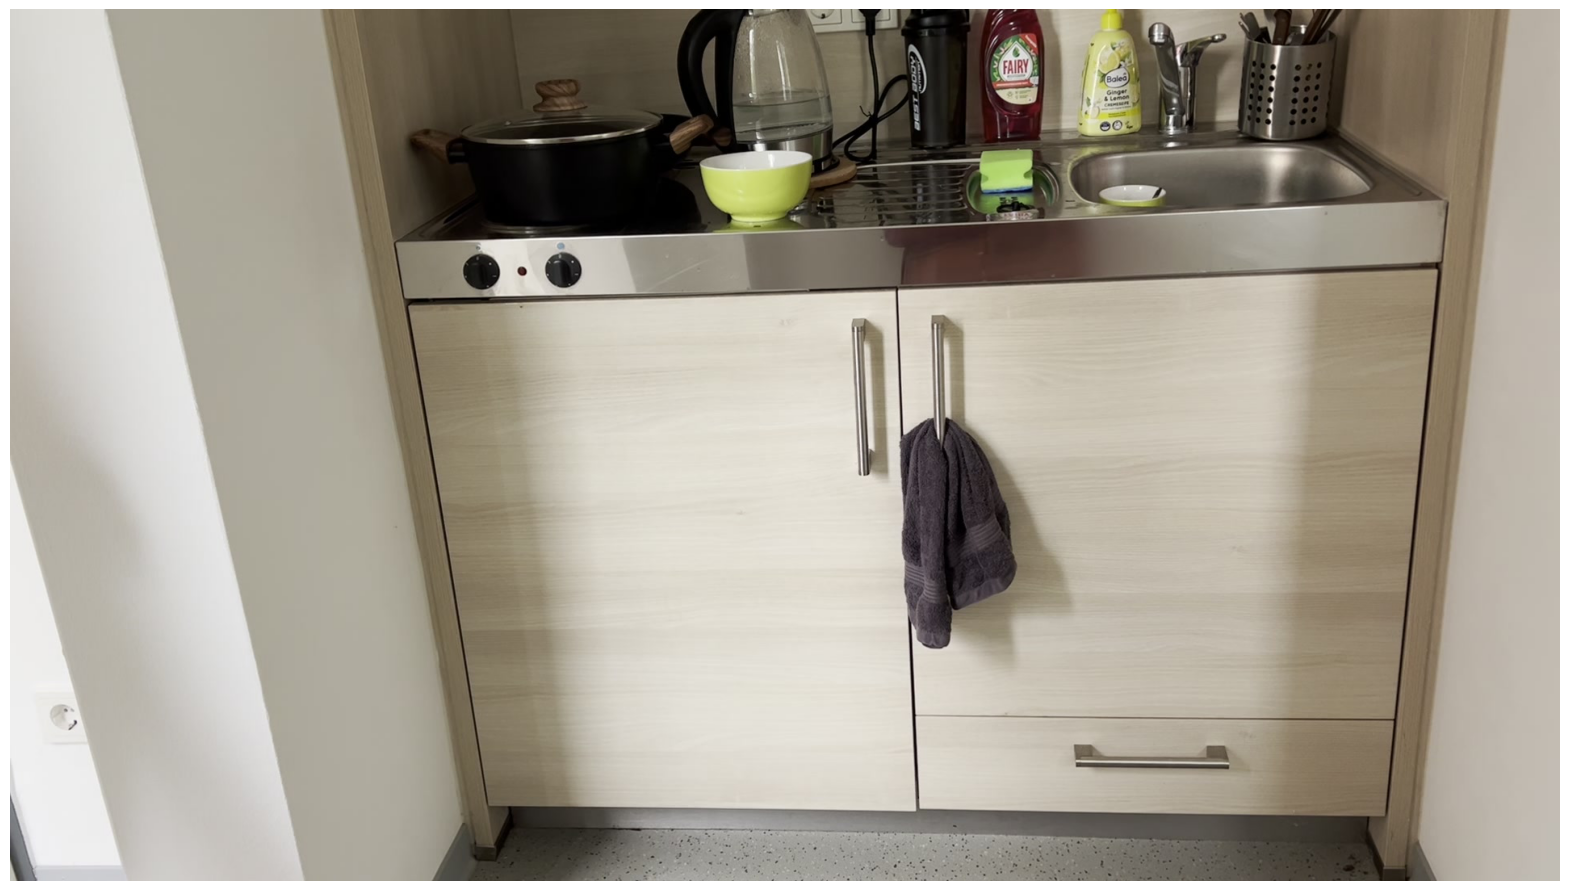

In [87]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

# Automatic mask generation

In [123]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../../segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
    sam2,
)

In [124]:
masks = mask_generator.generate(image)

In [125]:
print(len(masks))
print(masks[0].keys())

24
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [127]:
def get_masks_by_ids(masks, ids):
    return [masks[idx] for idx in ids]

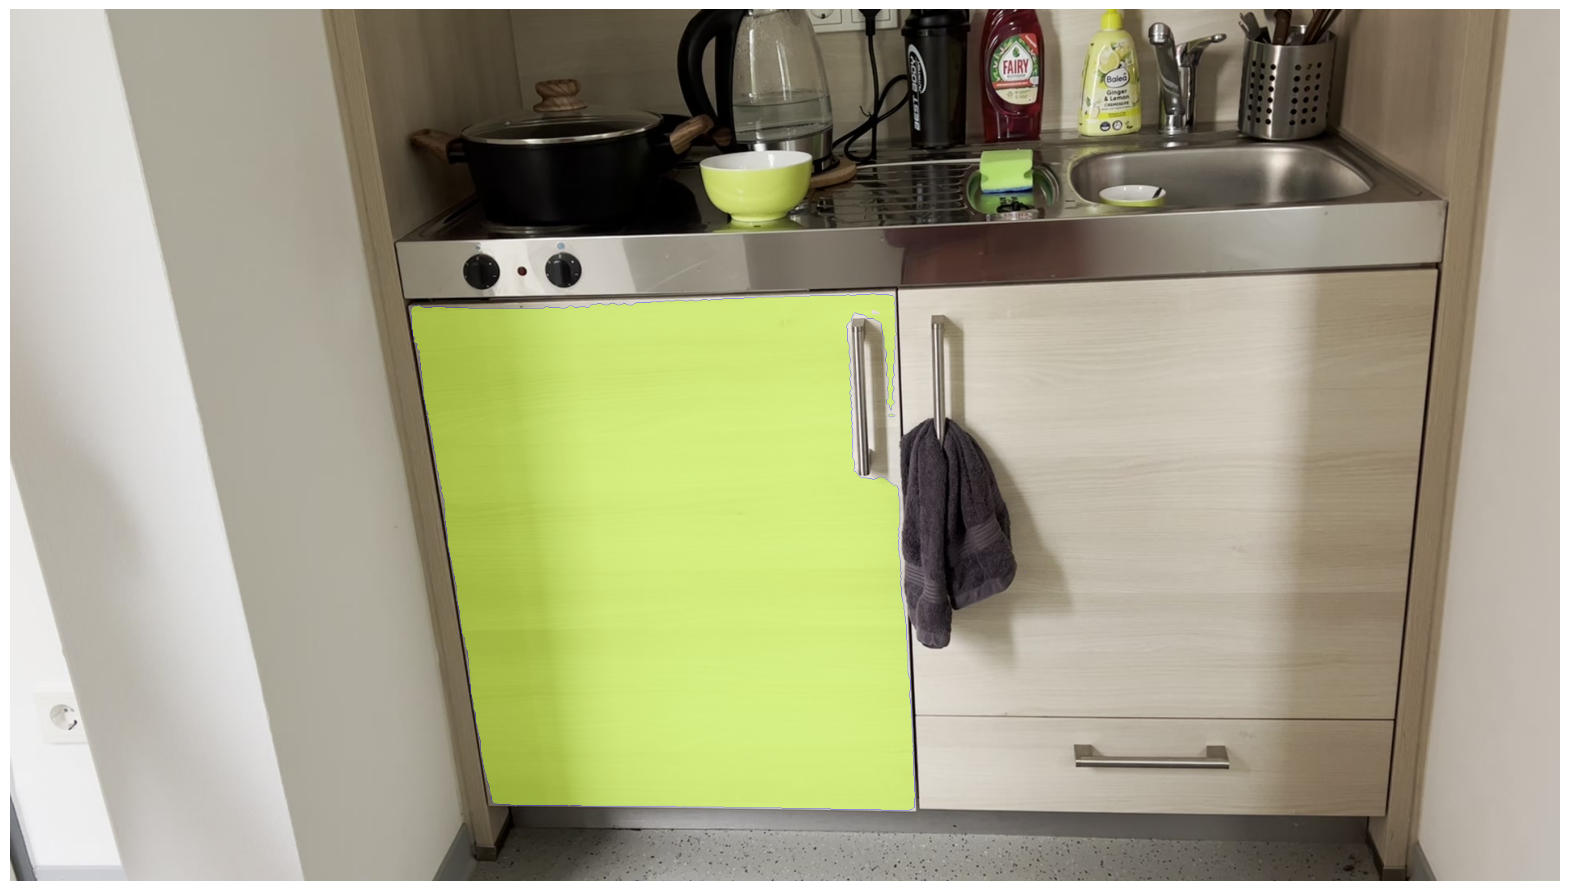

In [129]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(get_masks_by_ids(masks, [8]))
plt.axis('off')
plt.show() 

# Video propagation

In [92]:
import gc
del sam2
del mask_generator

torch.cuda.empty_cache()

# Force garbage collection to free up memory
gc.collect()

12041

In [93]:
from sam2.build_sam import build_sam2_video_predictor

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [94]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

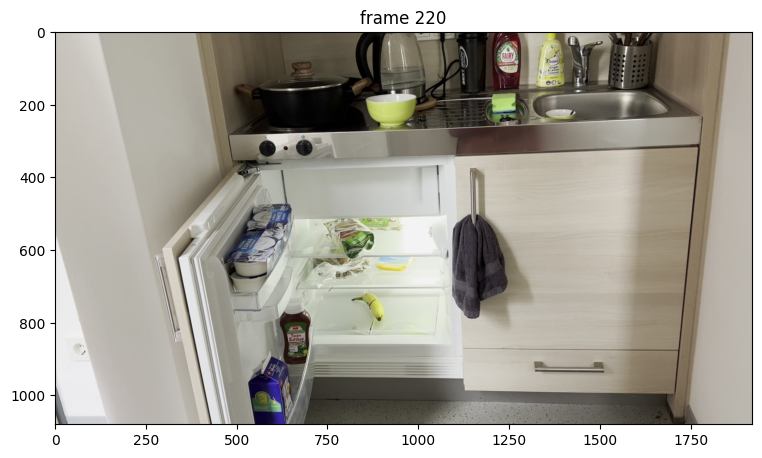

In [103]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "../../videos/extracted/fridge_open/"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 220
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [96]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|████████████████████████████████████████| 396/396 [00:15<00:00, 25.57it/s]


In [97]:
predictor.reset_state(inference_state)

In [98]:
prompts = {} # For all points for vis

/vol/isy-rl/prj-rgbd2mesh/dtrofimov/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/vol/isy-rl/prj-rgbd2mesh/dtrofimov/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


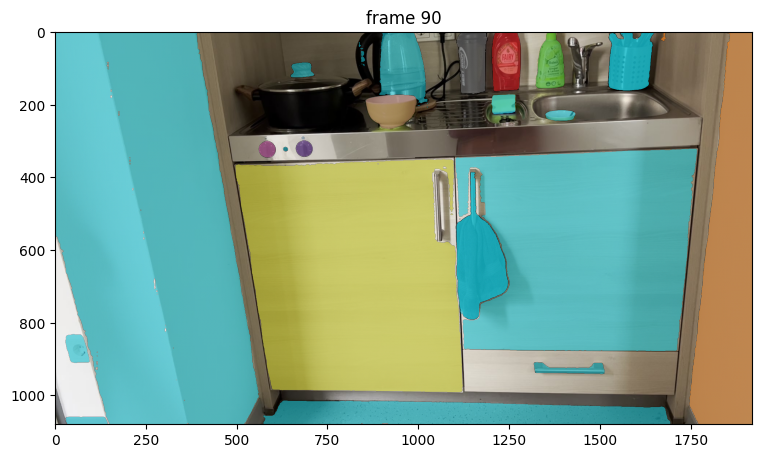

In [99]:
ann_frame_idx = 90
# Adding masks to the image
for ann_obj_id, mask in enumerate(masks):
    # `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
    points = np.array(mask["point_coords"], dtype=np.float32)
    labels = np.array([1] * len(mask["point_coords"]), np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    
# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
for i, out_obj_id in enumerate(out_obj_ids):
    #show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [100]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

propagate in video:  45%|██████████████████▊                       | 137/306 [05:16<06:47,  2.41s/it]/vol/isy-rl/dtrofimov/conda-isy/envs/sam2/lib/python3.11/site-packages/torch/nn/modules/module.py:1562: UserWarning: Flash Attention kernel failed due to: CUDA out of memory. Tried to allocate 5.26 GiB. GPU 0 has a total capacity of 23.64 GiB of which 2.05 GiB is free. Including non-PyTorch memory, this process has 21.52 GiB memory in use. Of the allocated memory 15.57 GiB is allocated by PyTorch, and 5.75 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).
  return forward_call(*args, **kwargs)
propagate in video:  45%|██████████████████▊               

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.26 GiB. GPU 0 has a total capacity of 23.64 GiB of which 2.05 GiB is free. Including non-PyTorch memory, this process has 21.52 GiB memory in use. Of the allocated memory 15.57 GiB is allocated by PyTorch, and 5.75 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [102]:
list(video_segments.keys())

[90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226]

In [33]:
mask_mean(video_segments[0][0][0])

array([144.34625122, 586.23317153])

In [177]:
def mask_mean(mask: np.ndarray):
    """Returns the center of the mask"""
    y_indices, x_indices = np.where(mask)
    mean_y = np.mean(y_indices)
    mean_x = np.mean(x_indices)
    return np.array([mean_x, mean_y])

def mask_cumulative_movement(masks_means: list):
    means_start = masks_means[:-1]
    means_end = masks_means[1:]
    return sum(
        (((end - start) ** 2).sum() ** (1/2)) if (not np.any(np.isnan(end)) and not np.any(np.isnan(start))) else 0.0 
        for start, end in zip(means_start, means_end)
    )
    
def extract_bbox(mask):
    # Find the coordinates of the non-zero (True) points in the mask
    y_coords, x_coords = np.where(mask)
    
    # Calculate the bounding box
    if len(y_coords) == 0 or len(x_coords) == 0:
        # If the mask is empty, return an empty bounding box
        return None
    
    x_min = np.min(x_coords)
    x_max = np.max(x_coords)
    y_min = np.min(y_coords)
    y_max = np.max(y_coords)
    
    # Format the bounding box as (x, y, width, height)
    bbox = (x_min, y_min, x_max - x_min + 1, y_max - y_min + 1)
    
    return bbox

def calculate_bbox_displacement_with_area_check(bbox1, bbox2):
    if bbox1 is None or bbox2 is None:
        return 0.0
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Displacement of the top-left corner only
    displacement_xy = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Check if area has significantly decreased
    area1 = w1 * h1
    area2 = w2 * h2
    if area2 < 0.99 * area1:  # Example threshold: 20% reduction in area
        return 0  # Ignore this displacement as it might be due to occlusion

    # Change in width and height
    displacement_wh = np.abs(w2 - w1) + np.abs(h2 - h1)
    
    # Total displacement
    total_displacement = displacement_xy + displacement_wh
    return total_displacement

def calculate_sum_bbox_displacement(bboxes):
    bbox_start = bboxes[:-1]
    bbox_end = bboxes[1:]
    
    return sum(
        calculate_bbox_displacement_with_area_check(b1, b2) for b1, b2 in zip(bbox_start, bbox_end)
    )

In [178]:
from collections import defaultdict
masks_thr_frames = defaultdict(list)
for frame, masks in video_segments.items():
    for mask_idx, mask in masks.items():
        masks_thr_frames[mask_idx].append(mask)

In [179]:
mask_id2bbox = {mask_idx: list(map(lambda x: extract_bbox(x[0]), masks)) for mask_idx, masks in masks_thr_frames.items()}

In [180]:
{mask_id: calculate_sum_bbox_displacement(bboxes) for mask_id, bboxes in mask_id2bbox.items()}

{0: 18.0,
 1: 400.0,
 2: 27.0,
 3: 28.0,
 4: 138.8378065889204,
 5: 136.23606797749977,
 6: 131.0855444687391,
 7: 20.0,
 8: 917.0735098106198,
 9: 480.9546086051558,
 10: 3100.617582157813,
 11: 42.0,
 12: 245.4342055687667,
 13: 56.0,
 14: 137.07106781186548,
 15: 81.24264068711928,
 16: 83.41421356237309,
 17: 265.42964732493795,
 18: 72.0,
 19: 55.0,
 20: 465.0541907077323,
 21: 48.41421356237309,
 22: 44.0,
 23: 153.1538303421637}

In [134]:
masks[8]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 342620,
 'bbox': [496.0, 352.0, 760.0, 640.0],
 'predicted_iou': 0.9453125,
 'point_coords': [[870.0, 961.875]],
 'stability_score': 0.9593763947486877,
 'crop_box': [0.0, 0.0, 1920.0, 1080.0]}

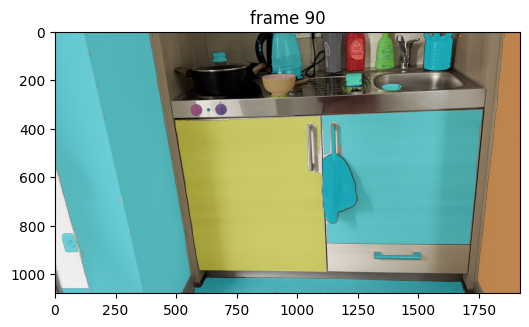

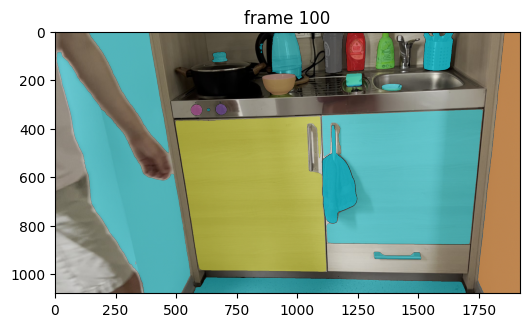

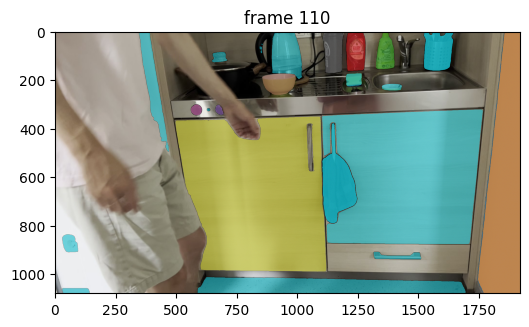

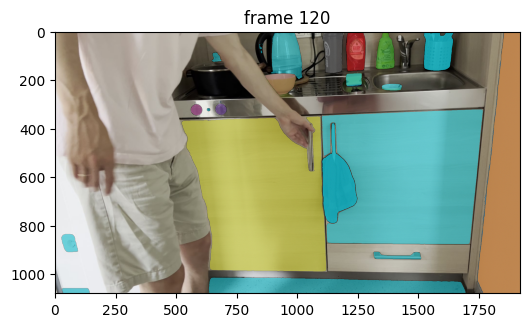

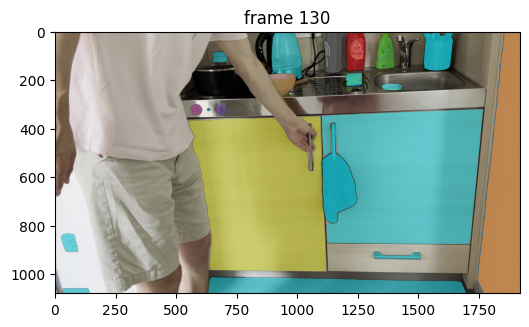

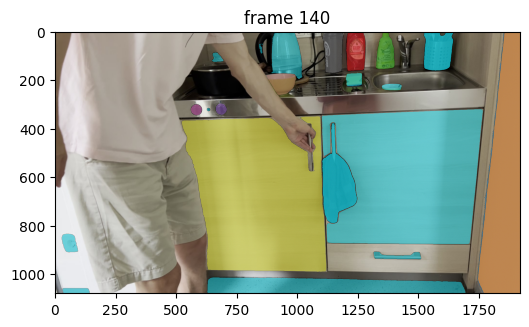

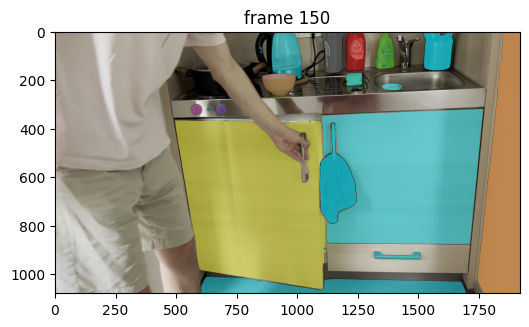

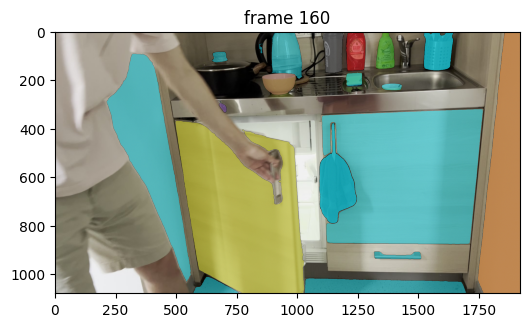

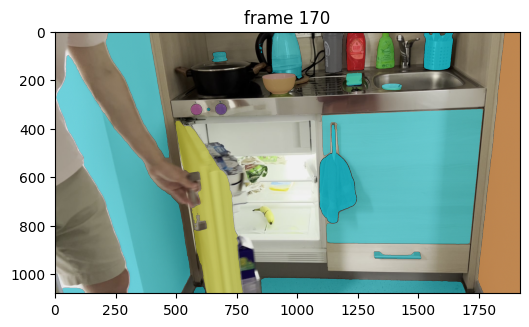

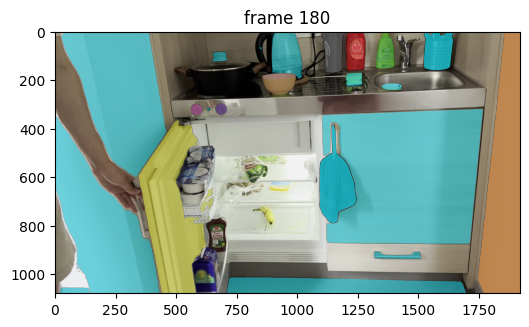

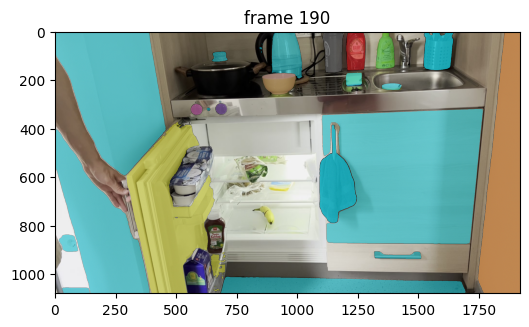

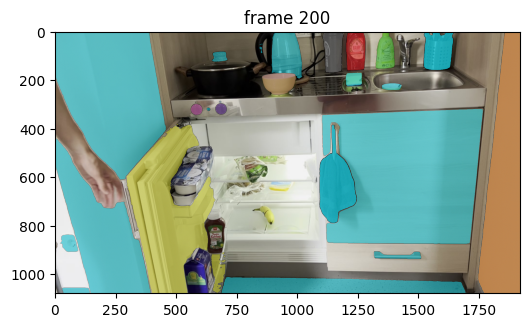

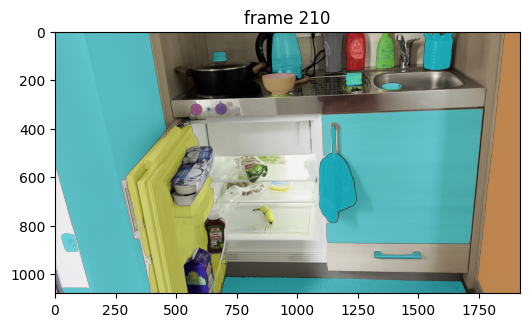

In [135]:
# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(90, 220, vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)